In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly
import warnings
from utils.data_helper import *
import yfinance as yf
from arch import arch_model
import xgboost as xgb
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from lightgbm import LGBMRegressor

warnings.filterwarnings('ignore')
pd.options.display.max_columns = 50
pd.options.display.max_rows = 200

In [2]:
end_date = datetime.today()
start_date = end_date - BDay(500)
symbol = 'AAPL'

In [3]:
 # Bug from yahoo API, it doesn't include price at end_date            
df = yf.download(tickers=symbol, interval="1d",auto_adjust=True, start=start_date, end=end_date)
df['return'] = 100 * df['Close'].pct_change().fillna(0)
win = 10
forecast = 10

df[f'rolling_vol_{win}d'] = df['return'].rolling(window=win, min_periods=win).std()
df['y'] = df[f'rolling_vol_{win}d']

[*********************100%***********************]  1 of 1 completed


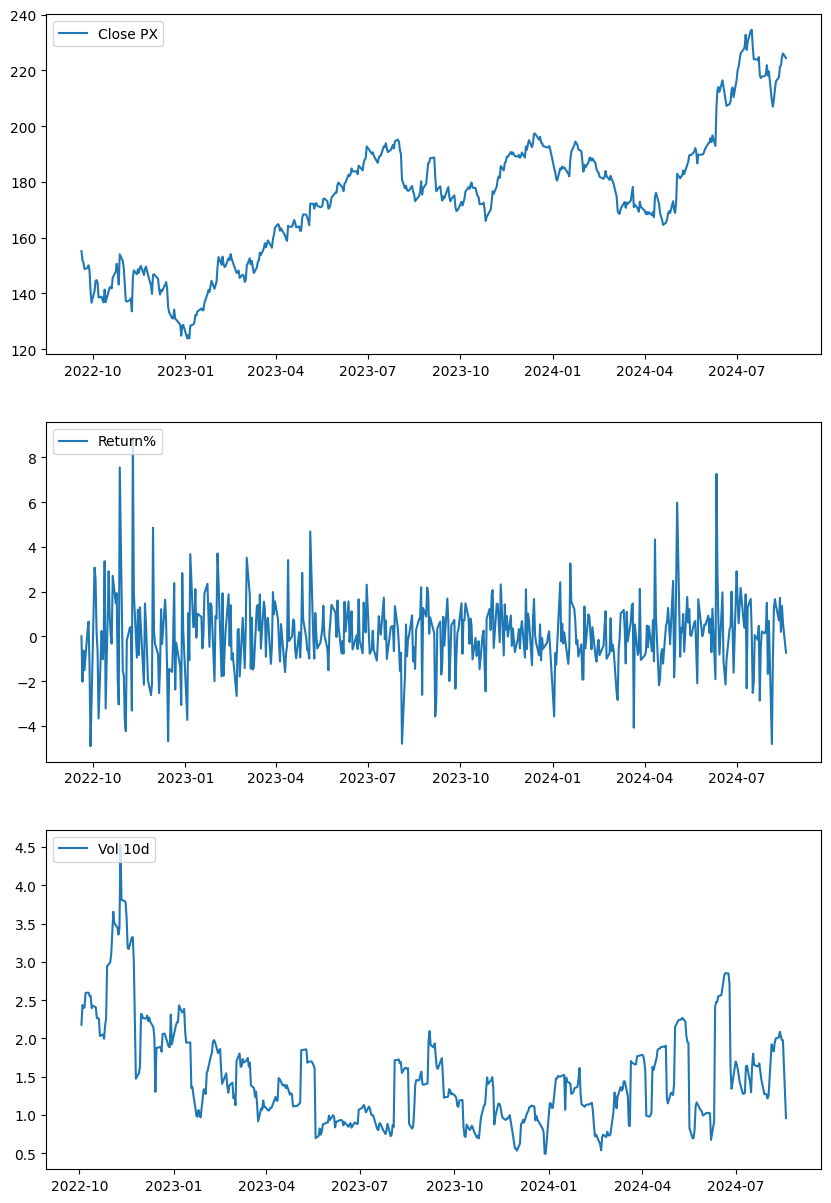

In [4]:
fig, axs = plt.subplots(3,1,figsize=(10,15))

ax = axs[0]
ax.plot(df['Close'], label='Close PX')
ax.legend(loc='upper left')

ax = axs[1]
ax.plot(df['return'], label='Return%')
ax.legend(loc='upper left')

ax = axs[2]
ax.plot(df[f'rolling_vol_{win}d'], label=f'Vol {win}d')
ax.legend(loc='upper left')

# Arch Model
- This is equivalent to create a arch model with rolling data and fit individually

- The date in forecast output is the last date 
    - Example: 14Aug24 and h1/h2/h3. This means as of 14Aug24 (14Aug24's data is in-sample), tmr forecast is h1, the day after tmr forecast is h2.

- Args first_obs and last_obs are equivalent to iloc. That means index of last_obs are not included in training

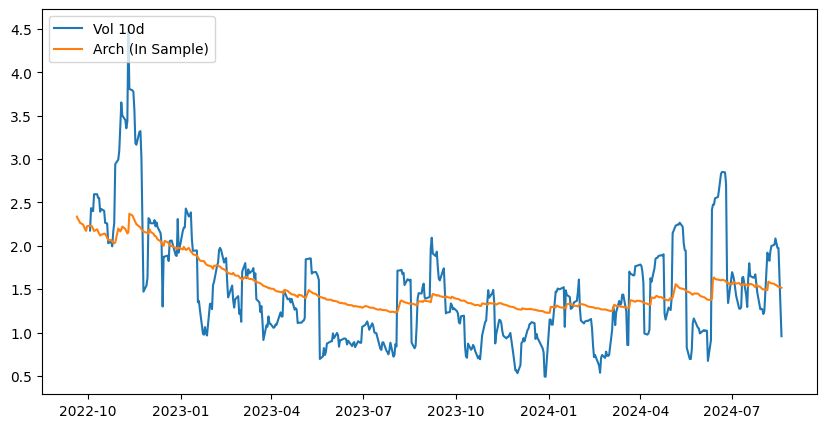

In [5]:
# In sample
model = arch_model(df['return'], vol="Garch", p=1, q=1, dist="Normal")
res = model.fit(disp=False)
pred_arch_in_sample = res.conditional_volatility

fig, axs = plt.subplots(1,1,figsize=(10,5))

ax = axs
ax.plot(df[f'rolling_vol_{win}d'], label=f'Vol {win}d')
ax.plot(pred_arch_in_sample, label=f'Arch (In Sample)')
ax.legend(loc='upper left')

In [6]:
# rolling trainings
model = arch_model(df['return'], vol="Garch", p=1, q=1, dist="Normal", mean='Zero')
train_days = win
vol_out_sample = []
n_iter = len(df)-train_days+1-forecast

with tqdm(total=n_iter) as pbar:
    for i in range(n_iter):    
        fdate = df.iloc[i+train_days-1+forecast].name
        lastd = df.iloc[i+train_days-1].name

        res = model.fit(first_obs=i, last_obs=i+train_days, disp='off')    
        vol = np.sqrt(res.forecast(horizon=win).variance)
        vol = vol.loc[lastd]
        vol.name = fdate
        vol_out_sample.append(vol)
        pbar.update(1)

pred_arch = pd.DataFrame(vol_out_sample)[f'h.{forecast}']

100%|██████████| 462/462 [00:04<00:00, 101.15it/s]


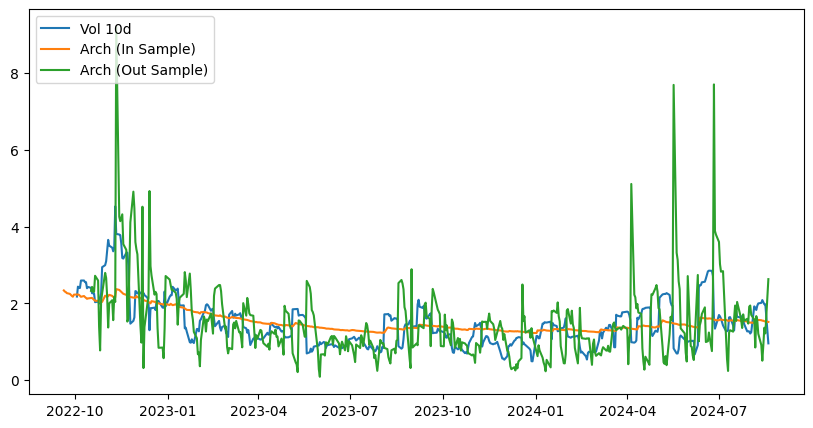

In [7]:
fig, axs = plt.subplots(1,1,figsize=(10,5))
ax = axs
ax.plot(df[f'rolling_vol_{win}d'], label=f'Vol {win}d')
ax.plot(pred_arch_in_sample, label=f'Arch (In Sample)')
ax.plot(pred_arch, label=f'Arch (Out Sample)')
ax.legend(loc='upper left')

# XGBoost
- ML approach to predict the volatility

- Forecast upcoming vol in N days given today's vol and price => need to shift the vol by N to get the label

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

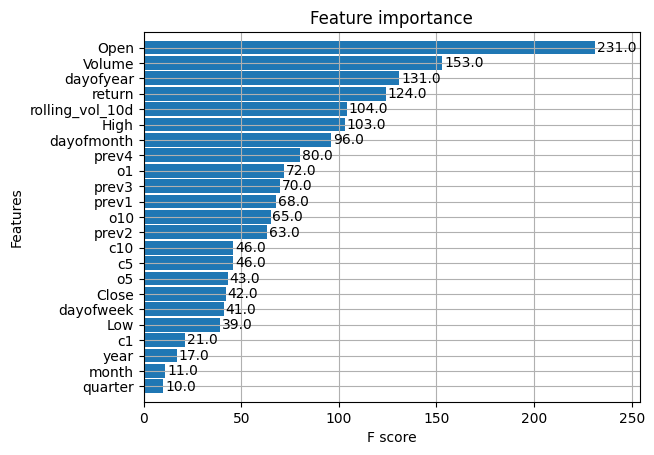

In [91]:
dfml = df.copy()

dfml['dayofweek'] = dfml.index.to_series().dt.day_of_week
dfml['quarter'] = dfml.index.to_series().dt.quarter
dfml['month'] = dfml.index.to_series().dt.month
dfml['year'] = dfml.index.to_series().dt.year
dfml['dayofyear'] = dfml.index.to_series().dt.day_of_year
dfml['dayofmonth'] = dfml.index.to_series().dt.day
dfml['prev1'] = dfml[f'rolling_vol_{win}d'].shift(1)
dfml['prev2'] = dfml[f'rolling_vol_{win}d'].shift(2)
dfml['prev3'] = dfml[f'rolling_vol_{win}d'].shift(3)
dfml['prev4'] = dfml[f'rolling_vol_{win}d'].shift(4)

dfml['o1'] = dfml['Open'].shift(1)
dfml['o5'] = dfml['Open'].shift(5)
dfml['o10'] = dfml['Open'].shift(10)

dfml['c1'] = dfml['Close'].shift(1)
dfml['c5'] = dfml['Close'].shift(5)
dfml['c10'] = dfml['Close'].shift(10)

# forcast future vol, so need to shift -forcast
dfml['y'] = dfml[f'rolling_vol_{win}d'].shift(-forecast)
dfml = dfml.fillna(0)

X = dfml.drop(columns=['y'])
y = dfml['y']

train_cutoff = int(len(df)*0.7)
X_train, y_train = X[:train_cutoff], y[:train_cutoff]
X_test, y_test = X[train_cutoff:], y[train_cutoff:]

#Defining and fitting the model
model = xgb.XGBRegressor(n_estimators=50,early_stopping_rounds=50)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

#Plot of feature importance
xgb.plot_importance(model, height=0.9)

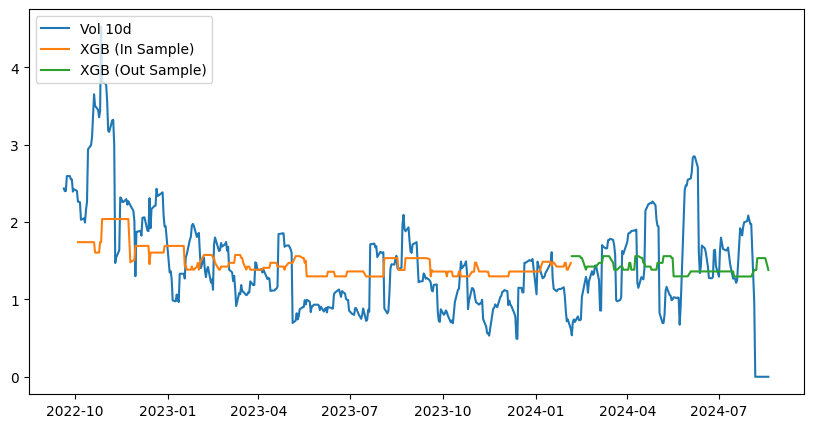

In [92]:
# In sample / out sample
xgb_in_sample = pd.Series(model.predict(X_train), df.iloc[forecast:train_cutoff+forecast].index)
xgb_out_sample = pd.Series(model.predict(X_test[:-forecast]), df.iloc[train_cutoff+forecast:].index)

fig, axs = plt.subplots(1,1,figsize=(10,5))
ax = axs
ax.plot(dfml['y'], label=f'Vol {win}d')
ax.plot(xgb_in_sample, label=f'XGB (In Sample)')
ax.plot(xgb_out_sample, label=f'XGB (Out Sample)')

ax.legend(loc='upper left')

In [93]:
# rolling tranings
model = xgb.XGBRegressor(n_estimators=1000,early_stopping_rounds=50)
train_days = win*10

res_vals = []
res_dts = []

iter_start = train_days+forecast
iter_end = len(dfml)-forecast

with tqdm(total = iter_end-iter_start) as pbar:
    for i in range(iter_start, iter_end):        

        # train data needs to be shifted by forcast day because the label does not exist
        tx = X.iloc[i-forecast-train_days+1:i-forecast+1]
        ty = y.iloc[i-forecast-train_days+1:i-forecast+1]        

        model.fit(tx, ty, eval_set=[(tx, ty)], verbose=False)        

        pred_x = X.iloc[i]
        pred_y = model.predict([pred_x])[0]
        pred_dt = X.iloc[i+forecast].name

        res_vals.append(pred_y)
        res_dts.append(pred_dt)                
        pbar.update(1)       

pred_xgb = pd.Series(res_vals, index=res_dts)

  0%|          | 0/361 [00:00<?, ?it/s]

100%|██████████| 361/361 [00:24<00:00, 14.58it/s]


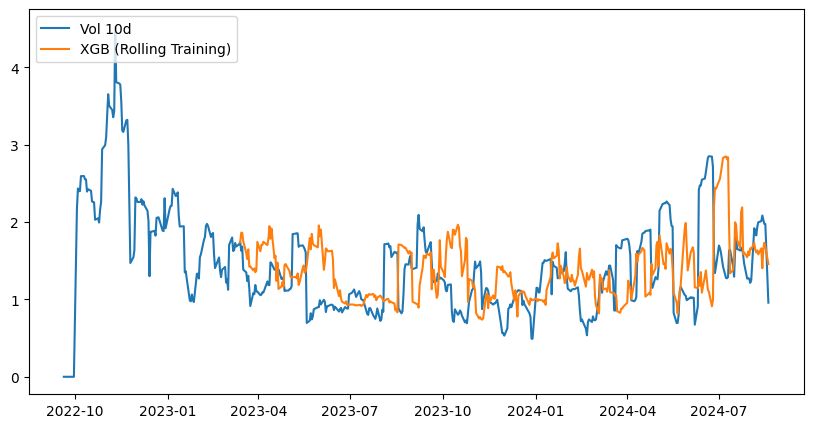

In [94]:
fig, axs = plt.subplots(1,1,figsize=(10,5))
ax = axs
ax.plot(dfml[f'rolling_vol_{win}d'], label=f'Vol {win}d')
ax.plot(pred_xgb, label=f'XGB (Rolling Training)')
ax.legend(loc='upper left')

# Suppert Vector Regression


In [95]:
dfml = df.copy()
dfml['Open'] = dfml['Open'] / dfml.iloc[0]
dfml['Close'] = dfml['Close'] / dfml.iloc[0]
dfml['High'] = dfml['High'] / dfml.iloc[0]
dfml['Low'] = dfml['Low'] / dfml.iloc[0]


dfml['dayofweek'] = dfml.index.to_series().dt.day_of_week
dfml['quarter'] = dfml.index.to_series().dt.quarter
dfml['month'] = dfml.index.to_series().dt.month
dfml['year'] = dfml.index.to_series().dt.year
dfml['dayofyear'] = dfml.index.to_series().dt.day_of_year
dfml['dayofmonth'] = dfml.index.to_series().dt.day

dfml['prev1'] = dfml[f'rolling_vol_{win}d'].shift(1)
dfml['prev2'] = dfml[f'rolling_vol_{win}d'].shift(2)
dfml['prev3'] = dfml[f'rolling_vol_{win}d'].shift(3)
dfml['prev4'] = dfml[f'rolling_vol_{win}d'].shift(4)
dfml['o1'] = dfml['Open'].shift(1)
dfml['o5'] = dfml['Open'].shift(5)
dfml['o10'] = dfml['Open'].shift(10)

dfml['c1'] = dfml['Close'].shift(1)
dfml['c5'] = dfml['Close'].shift(5)
dfml['c10'] = dfml['Close'].shift(10)

# forcast future vol, so need to shift -forcast
dfml['y'] = dfml[f'rolling_vol_{win}d'].shift(-forecast)
dfml = dfml.fillna(0)

X = dfml.drop(columns=['y'])
y = dfml['y']

train_cutoff = int(len(df)*0.7)
X_train, y_train = X[:train_cutoff], y[:train_cutoff]
X_test, y_test = X[train_cutoff:], y[train_cutoff:]

#Defining and fitting the model
model = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
model.fit(X_train, y_train)

SVR(C=100, gamma=0.1)

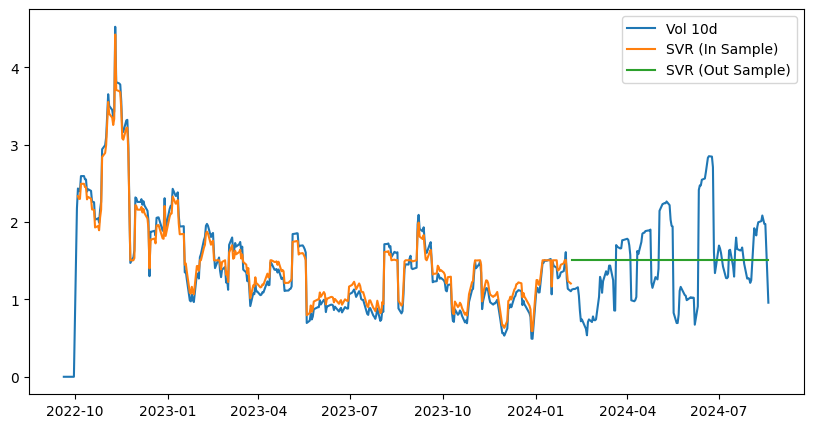

In [96]:
# In sample / out sample
svr_in_sample = pd.Series(model.predict(X_train), df.iloc[forecast:train_cutoff+forecast].index)
svr_out_sample = pd.Series(model.predict(X_test[:-forecast]), df.iloc[train_cutoff+forecast:].index)

fig, axs = plt.subplots(1,1,figsize=(10,5))
ax = axs
ax.plot(dfml[f'rolling_vol_{win}d'], label=f'Vol {win}d')
ax.plot(svr_in_sample, label=f'SVR (In Sample)')
ax.plot(svr_out_sample, label=f'SVR (Out Sample)')
ax.legend()

In [97]:
# rolling tranings
model = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
train_days = win

res_vals = []
res_dts = []

iter_start = train_days+forecast
iter_end = len(dfml)-forecast

with tqdm(total = iter_end-iter_start) as pbar:
    for i in range(iter_start, iter_end):        

        # train data needs to be shifted by forcast day because the label does not exist
        tx = X.iloc[i-forecast-train_days+1:i-forecast+1]
        ty = y.iloc[i-forecast-train_days+1:i-forecast+1]        

        model.fit(tx, ty)        

        pred_x = X.iloc[i]
        pred_y = model.predict([pred_x])[0]
        pred_dt = X.iloc[i+forecast].name

        res_vals.append(pred_y)
        res_dts.append(pred_dt)                
        pbar.update(1)        

pred_svr = pd.Series(res_vals, index=res_dts)

100%|██████████| 451/451 [00:00<00:00, 1263.39it/s]


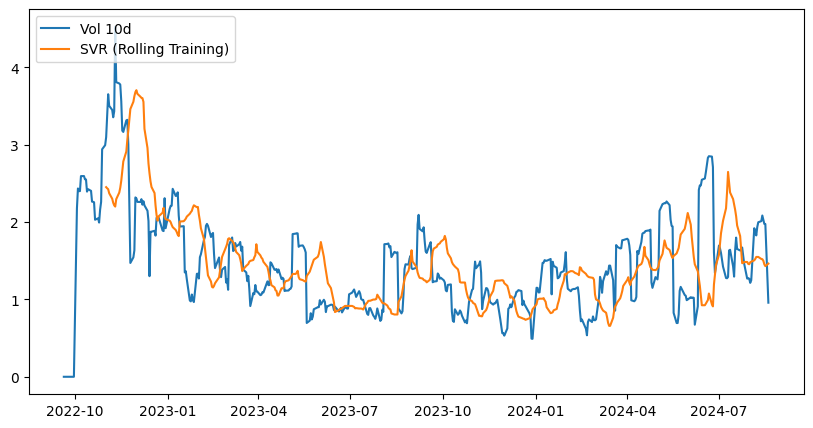

In [98]:
fig, axs = plt.subplots(1,1,figsize=(10,5))
ax = axs
ax.plot(dfml[f'rolling_vol_{win}d'], label=f'Vol {win}d')
ax.plot(pred_svr, label=f'SVR (Rolling Training)')
ax.legend(loc='upper left')

# Autoregressive Forecast with Random Forest

In [99]:
dfml = df.copy()
dfml['y'] = dfml['y'].fillna(0)

model = ForecasterAutoreg(regressor = RandomForestRegressor(random_state=123),lags = 6)
model.fit(y=dfml['y'])
model.get_feature_importances()

,feature,importance
0,lag_1,0.910347
1,lag_2,0.025389
4,lag_5,0.016835
2,lag_3,0.016793
3,lag_4,0.016295
5,lag_6,0.014340


In [100]:
# rolling trainings
train_days = win*3
pred_arr = []
iter_start = train_days
iter_end = len(dfml)-forecast+1

model = ForecasterAutoreg(regressor = RandomForestRegressor(random_state=123),lags = 6)

with tqdm(total=iter_end-iter_start) as pbar:
    for i in range(iter_start, iter_end):    
        ty = dfml['y'].iloc[i-train_days:i]
        fdate = dfml.iloc[i+forecast-1].name  
        
        model.fit(y=ty)        

        pred_y = model.predict(steps=forecast).iloc[-1]
        pred_y = pd.Series(pred_y, index=[fdate])

        pred_arr.append(pred_y)
        pbar.update(1)        

pred_af_rf = pd.concat(pred_arr)

100%|██████████| 442/442 [00:26<00:00, 16.46it/s]


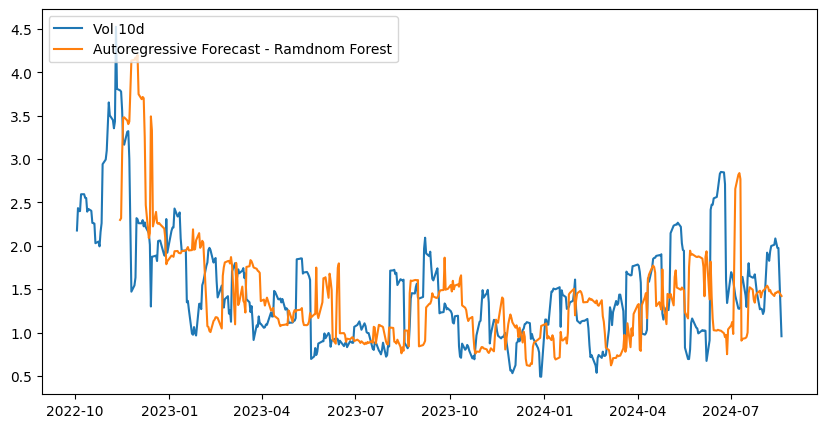

In [101]:
fig, axs = plt.subplots(1,1,figsize=(10,5))
ax = axs
ax.plot(dfml[f'rolling_vol_{win}d'], label=f'Vol {win}d')
ax.plot(pred_af_rf, label=f'Autoregressive Forecast - Ramdnom Forest')
ax.legend(loc='upper left')

# Autoregessive Forecast with LightGBM

In [102]:
dfml = df.copy()
dfml['y'] = dfml['y'].fillna(0)

model = ForecasterAutoreg(regressor = LGBMRegressor(random_state=123, verbosity=-1),lags = 6)
model.fit(y=dfml['y'])
model.get_feature_importances()

,feature,importance
0,lag_1,377
5,lag_6,321
3,lag_4,307
2,lag_3,268
1,lag_2,267
4,lag_5,226


In [103]:
# rolling trainings
train_days = win
pred_arr = []
iter_start = train_days
iter_end = len(dfml)-forecast+1

model = ForecasterAutoreg(regressor = LGBMRegressor(random_state=123, verbosity=-1),lags = 5)

with tqdm(total=iter_end-iter_start) as pbar:
    for i in range(iter_start, iter_end):    
        ty = dfml['y'].iloc[i-train_days:i]
        fdate = dfml.iloc[i+forecast-1].name  
        
        model.fit(y=ty)        

        pred_y = model.predict(steps=forecast).iloc[-1]
        pred_y = pd.Series(pred_y, index=[fdate])

        pred_arr.append(pred_y)
        pbar.update(1)        

pred_af_lgbm = pd.concat(pred_arr)

100%|██████████| 462/462 [00:03<00:00, 141.91it/s]


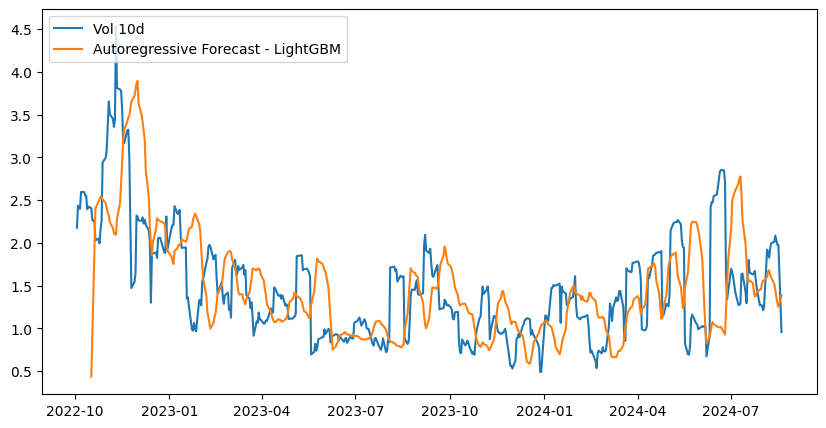

In [104]:
fig, axs = plt.subplots(1,1,figsize=(10,5))
ax = axs
ax.plot(dfml[f'rolling_vol_{win}d'], label=f'Vol {win}d')
ax.plot(pred_af_lgbm, label=f'Autoregressive Forecast - LightGBM')
ax.legend(loc='upper left')

In [105]:
# Custom function to calculate Directional Accuracy
def directional_accuracy(actual_values, predicted_values):
    correct_directions = sum((actual_values[i] - actual_values[i-1]) * (predicted_values[i] - predicted_values[i-1]) > 0 for i in range(1, len(actual_values)))
    total_predictions = len(actual_values) - 1  # Total number of predictions (excluding the first one)    
    da = correct_directions / total_predictions if total_predictions > 0 else 0
    return da

def summary_table(actual, lastn, models):
    res = []
    for model in models:         
        res.append([
            model[0],
            mean_squared_error(actual[-lastn:], model[1][-lastn:], squared=False),
            mean_absolute_percentage_error(actual[-lastn:], model[1][-lastn:]),
            directional_accuracy(actual[-lastn:].values, model[1][-lastn:].values)
        ])

    res = pd.DataFrame(res, columns=['model', 'rmse', 'mape', 'directional_accuracy'])
    return res

In [108]:
summary_table(df['y'], 300, [
    ['Rolling Vol', df['y'].shift(forecast)],
    ['ARCH', pred_arch],
    ['XGB', pred_xgb],
    ['SVR', pred_svr],    
    ['AutoReg Random Forest', pred_af_rf],
    ['AutoReg LightGBM', pred_af_lgbm],
])

,model,rmse,mape,directional_accuracy
0,Rolling Vol,0.626858,0.386270,0.387960
1,ARCH,0.992039,0.563795,0.377926
2,XGB,0.576881,0.372611,0.525084
3,SVR,0.546788,0.347666,0.428094
4,AutoReg Random Forest,0.574374,0.366829,0.408027
5,AutoReg LightGBM,0.571773,0.353449,0.464883
